# Modeling

In this notebook I create the final machine learning models to predict house prices. I will be trying out different feature combinations, different hyperparameter values, and I will experiment with using the log-transformed price and regular price as target values for the models.

In [21]:
#import libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, r2_score

In [22]:
# import data
df = pd.read_csv("train.csv")

#remove outliers
df = df.sort_values("log_price")[:-5]

# shuffle
df = df.sample(frac=1)

df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,long,sqft_living15,sqft_lot15,log_price,log_sqft_above,log_sqft_living,log_sqft_living15,log_sqft_lot,log_sqft_lot15,mean_log_price_zip
10401,915000.0,3,2.25,2390,2750,2.0,0,0,5,8,...,-122.354,2200,5160,13.726679,7.365180,7.779049,7.696213,7.919356,8.548692,13.584897
12110,145000.0,3,1.00,1010,5490,1.0,0,0,3,6,...,-122.293,1740,10658,11.884489,6.917706,6.917706,7.461640,8.610684,9.274066,12.353254
15447,1900000.0,5,4.25,6510,16471,2.0,0,3,4,11,...,-122.242,4480,16471,14.457364,8.086410,8.781095,8.407378,9.709357,9.709357,13.914010
9507,350500.0,3,1.75,2080,5200,1.0,0,0,3,7,...,-122.350,1410,6550,12.767116,6.946976,7.640123,7.251345,8.556414,8.787220,12.903567
14787,1250000.0,5,5.00,5000,32909,2.0,0,0,3,10,...,-122.022,3030,12601,14.038654,8.517193,8.517193,8.016318,10.401501,9.441531,13.532819


# 1.1 Preprocessing

Now I will seperate the data into X and y sets, as well as scale the data with standardization.

In [23]:
X_df = df.drop(["log_price", "price"], axis=1)
log_y = df["log_price"]
y = df["price"]

sc = StandardScaler()
X = sc.fit_transform(X_df)

X = pd.DataFrame(X, columns=X_df.columns)

# 1.3 Linear Regression

I will use ridge regression with different combinations of features and see which are the best. Then I will tune the regularization hyperparameter to see if that can improve the results.

In [24]:
ridge = Ridge()

# 1.4 RFE

Now I will select the best features using recursive feature elimination. I will plot out graphs showing the scores with different amounts of featurs.

In [25]:
# try out different combinations of features, also try a model using log price and a model using regular price

log_rfes = []
norm_rfes = []
log_scores = []
norm_scores = []
n_feats = list(range(1, 10))

# for number between 1 and 10 create an rfe object, fit, and save scores
for i in n_feats:
    
    log_rfe = RFE(ridge, i).fit(X, log_y)
    norm_rfe = RFE(ridge, i).fit(X, y)
    
    log_rfes.append(log_rfe)
    norm_rfes.append(norm_rfe)
    
    log_scores.append(cross_val_score(log_rfe, X, log_y, cv=5, scoring="neg_mean_squared_error").sum()/-5)
    norm_scores.append(cross_val_score(norm_rfe, X, y, cv=5, scoring="neg_median_absolute_error").sum()/-5)


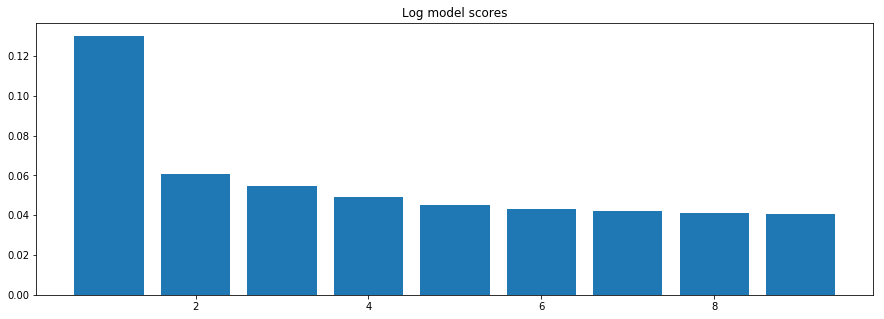

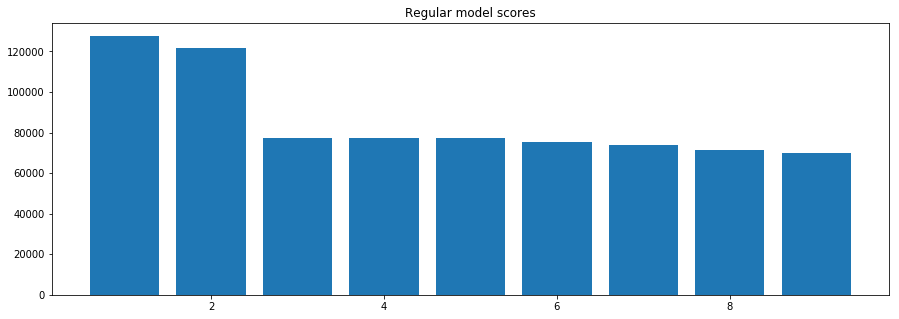

In [26]:
# plot results
plt.figure(figsize=(15, 5))
plt.bar(n_feats, log_scores)
plt.title("Log model scores")
plt.show()

plt.figure(figsize=(15, 5))
plt.bar(n_feats, norm_scores)
plt.title("Regular model scores")
plt.show()

It seems that the optimal amount of features for the log model is 2 and the optimal amount of features for the regular model is 3. Now I will save those selected features in lists.

In [27]:
best_feats_log = []
for col, is_selected in zip(X.columns, log_rfes[1].support_):
    if is_selected:
        best_feats_log.append(col)
        
best_feats_log

['log_sqft_living', 'mean_log_price_zip']

In [28]:
best_feats_norm = []
for col, is_selected in zip(X.columns, norm_rfes[2].support_):
    if is_selected:
        best_feats_norm.append(col)
        
best_feats_norm

['sqft_living', 'log_sqft_living', 'mean_log_price_zip']

now I will create new X variables with only those features.

In [29]:
log_X = X[best_feats_log]
norm_X = X[best_feats_norm]

# 1.5 Hyper Parameter Tuning

Now I will try changing the regularization parameter "alpha" to see if it improves performance. I will do this for both models, the one based on the price and the one based on the log of the price.

In [30]:
# find best parameters for the model using price

# try searching for better alpha (regularization) values
gs = GridSearchCV(ridge, {"alpha":[0.1, 0.5, 1, 2, 10]}, cv=5, scoring="r2")
gs.fit(norm_X, y)
# find best alpha
print(gs.best_params_)
# print score
print(gs.best_score_)

{'alpha': 10}
0.7018877934883099


In [31]:
# find best parameters for the model using the log of price

# try searching for better alpha (regularization) values
gs = GridSearchCV(ridge, {"alpha":[0.1, 0.5, 1, 2, 10]}, cv=5, scoring="r2")
gs.fit(log_X, log_y)
# find best alpha
print(gs.best_params_)
# print score
print(gs.best_score_)

{'alpha': 2}
0.7795918124930346


It seems like an alphas of 2 and 1 will work well.

Now I will check that the errors are normally distributed and that there is no heteroskedascicity (change in variance of errors).

In [32]:
# create 2 models for different hyperparameters 
# one for using the log price and one for the regular price
norm_ridge = Ridge(alpha=2)
log_ridge = Ridge(alpha=1)

# fit and predict with models to find errors
norm_yhat = cross_val_predict(norm_ridge, norm_X, y)
norm_errors = norm_yhat - y

log_yhat = cross_val_predict(log_ridge, log_X, log_y)
log_errors = log_yhat - log_y

def error_plots(errors, yhat):
    # plot for normality
    plt.figure(figsize=(15, 5))
    sns.kdeplot(errors)
    plt.title("Normaility Of Errors")
    plt.show()

    # plot for heteroskedascity
    plt.figure(figsize=(15, 5))
    plt.scatter(yhat, errors, alpha=0.5)
    plt.axhline(errors.mean(), color="red")
    plt.title("Variance Of Errors With Scale (Heteroskedascity)")
    plt.show()

C:\Users\zasz\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\zasz\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


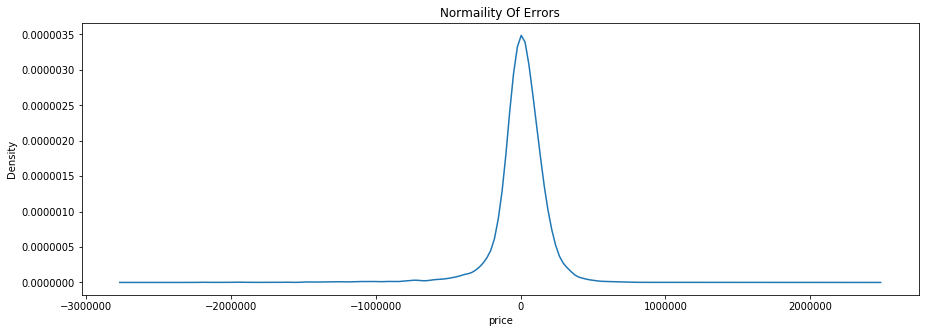

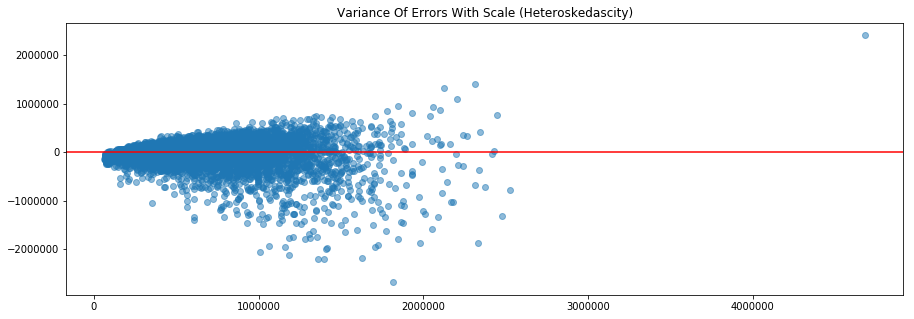

In [33]:
# plot results for regular model
error_plots(norm_errors, norm_yhat)

We can see that the regular model has heteroskedascity making it an unreliable model.

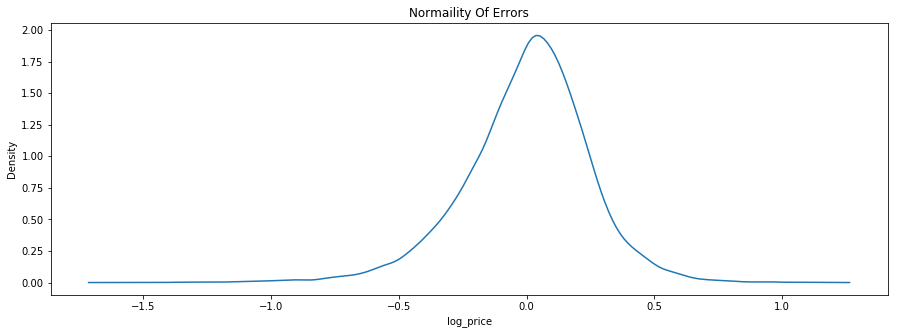

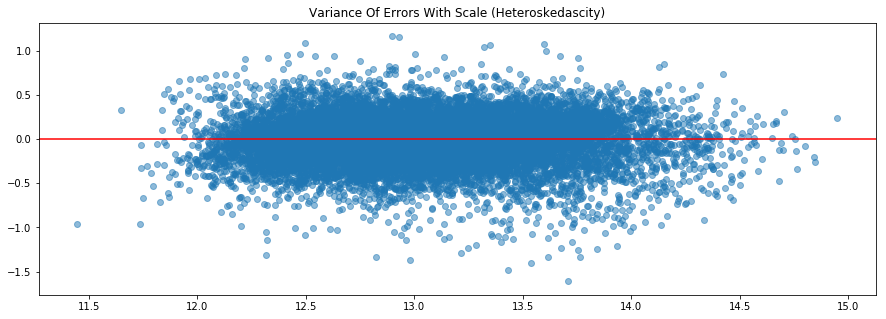

In [34]:
# plot results for model using log price
error_plots(log_errors, log_yhat)

The model using log price seems fine.

## Interpreting Results

Now it is time to interpret the model. First let's take a look at the R-squared

In [35]:
# print r2 score 
r2_score(log_y, log_yhat)

0.7795895290504091

In [36]:
# print features for log model
best_feats_log

['log_sqft_living', 'mean_log_price_zip']

The R-squared value indicates that the log of the price is approximately %78 related to the mean zipcode log price and the sqft living space. In other words atleast %22 of the log price is not predictable with this model and these features. Next let's look at the accuracy of the model with root mean squared error and mean absolute error.

In [37]:
# find rmse
np.sqrt(mean_squared_error(log_y, log_yhat))

0.24674694135737474

In [38]:
# find mean absolute error
sum(abs(log_errors))/len(log_errors)

0.18540330034556943

The rmse is more sensitive to outliers than the mae. Lets convert back to U.S. dollars and look at the mean absolute error, which is the average distance the predictions are to the real values.

In [39]:
# mean absolute error in USD
sum(abs(np.exp(log_y) - np.exp(log_yhat))) / len(log_yhat)

106096.27173374049

In [40]:
# find median price
y.median()

450000.0

On average the model is about 106,000 dollars off. Compare that with the mean house price of 450,000 dollars